# Method 8 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

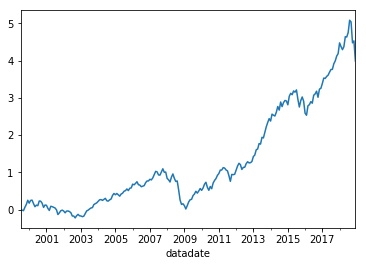

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.249462
2000-12-31   -0.102020
2001-12-31   -0.122256
2002-12-31   -0.154250
2003-12-31    0.416772
2004-12-31    0.212625
2005-12-31    0.104744
2006-12-31    0.118565
2007-12-31    0.135032
2008-12-31   -0.424039
2009-12-31    0.354234
2010-12-31    0.225542
2011-12-31    0.014796
2012-12-31    0.176232
2013-12-31    0.502204
2014-12-31    0.138040
2015-12-31   -0.001883
2016-12-31    0.088816
2017-12-31    0.218675
2018-12-31   -0.038327
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     573.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.00e-118
Time:                        06:48:13   Log-Likelihood:                 665.96
No. Observations:                 234   AIC:                            -1322.
Df Residuals:                     229   BIC:                            -1305.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.982      0.003       0.001       0.005
mktrf          0.9907      0.026     37.392      0.000       0.938       1.043
me             0.2364      0.031      7.672      0.000       0.176       0.297
ia            -0.0931      0.047     -1.988      0.048      -0.185      -0.001
roe            0.1131      0.040      2.820      0.005       0.034       0.192
==============================================================================
Omnibus:                        9.305   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.426
Skew:                           0.024   Prob(JB):                     9.97e-05
Kurtosis:                       4.374   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     457.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.13e-108
Time:                        06:48:13   Log-Likelihood:                 665.96
No. Observations:                 234   AIC:                            -1322.
Df Residuals:                     229   BIC:                            -1305.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.384      0.001       0.001       0.005
mktrf          0.9907      0.037     26.540      0.000       0.918       1.064
me             0.2364      0.040      5.985      0.000       0.159       0.314
ia            -0.0931      0.083     -1.121      0.262      -0.256       0.070
roe            0.1131      0.051      2.236      0.025       0.014       0.212
==============================================================================
Omnibus:                        9.305   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.426
Skew:                           0.024   Prob(JB):                     9.97e-05
Kurtosis:                       4.374   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     598.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.76e-120
Time:                        06:48:13   Log-Likelihood:                 665.96
No. Observations:                 234   AIC:                            -1322.
Df Residuals:                     229   BIC:                            -1305.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.506      0.000       0.001       0.004
mktrf          0.9907      0.039     25.136      0.000       0.913       1.068
me             0.2364      0.038      6.251      0.000       0.162       0.311
ia            -0.0931      0.082     -1.137      0.255      -0.254       0.067
roe            0.1131      0.048      2.339      0.019       0.018       0.208
==============================================================================
Omnibus:                        9.305   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               18.426
Skew:                           0.024   Prob(JB):                     9.97e-05
Kurtosis:                       4.374   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     425.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.76e-113
Time:                        06:48:13   Log-Likelihood:                 658.53
No. Observations:                 234   AIC:                            -1305.
Df Residuals:                     228   BIC:                            -1284.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.042      0.003       0.001       0.005
mktrf          0.9786      0.027     35.634      0.000       0.924       1.033
smb            0.2355      0.036      6.499      0.000       0.164       0.307
hml           -0.1004      0.043     -2.350      0.020      -0.185      -0.016
rmw            0.0544      0.048      1.125      0.262      -0.041       0.150
cma            0.0189      0.061      0.307      0.759      -0.102       0.140
==============================================================================
Omnibus:                       13.799   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.403
Skew:                           0.028   Prob(JB):                     1.25e-08
Kurtosis:                       4.931   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     647.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.71e-132
Time:                        06:48:13   Log-Likelihood:                 658.53
No. Observations:                 234   AIC:                            -1305.
Df Residuals:                     228   BIC:                            -1284.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.282      0.001       0.001       0.005
mktrf          0.9786      0.037     26.476      0.000       0.906       1.051
smb            0.2355      0.048      4.867      0.000       0.141       0.330
hml           -0.1004      0.063     -1.586      0.113      -0.224       0.024
rmw            0.0544      0.048      1.127      0.260      -0.040       0.149
cma            0.0189      0.116      0.163      0.871      -0.208       0.246
==============================================================================
Omnibus:                       13.799   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.403
Skew:                           0.028   Prob(JB):                     1.25e-08
Kurtosis:                       4.931   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     876.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.22e-146
Time:                        06:48:14   Log-Likelihood:                 658.53
No. Observations:                 234   AIC:                            -1305.
Df Residuals:                     228   BIC:                            -1284.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.340      0.001       0.001       0.005
mktrf          0.9786      0.038     25.715      0.000       0.904       1.053
smb            0.2355      0.054      4.377      0.000       0.130       0.341
hml           -0.1004      0.066     -1.517      0.129      -0.230       0.029
rmw            0.0544      0.045      1.217      0.223      -0.033       0.142
cma            0.0189      0.119      0.159      0.874      -0.214       0.251
==============================================================================
Omnibus:                       13.799   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.403
Skew:                           0.028   Prob(JB):                     1.25e-08
Kurtosis:                       4.931   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     587.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.28e-119
Time:                        06:48:14   Log-Likelihood:                 668.48
No. Observations:                 234   AIC:                            -1327.
Df Residuals:                     229   BIC:                            -1310.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.027      0.003       0.001       0.005
mktrf          1.0167      0.024     42.128      0.000       0.969       1.064
smb            0.1622      0.030      5.385      0.000       0.103       0.222
hml           -0.0099      0.030     -0.331      0.741      -0.069       0.049
umd            0.1026      0.020      5.226      0.000       0.064       0.141
==============================================================================
Omnibus:                       12.112   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.906
Skew:                           0.017   Prob(JB):                     5.29e-07
Kurtosis:                       4.722   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     699.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.60e-127
Time:                        06:48:14   Log-Likelihood:                 668.48
No. Observations:                 234   AIC:                            -1327.
Df Residuals:                     229   BIC:                            -1310.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.309      0.001       0.001       0.005
mktrf          1.0167      0.032     31.886      0.000       0.954       1.079
smb            0.1622      0.056      2.888      0.004       0.052       0.272
hml           -0.0099      0.063     -0.158      0.874      -0.133       0.113
umd            0.1026      0.032      3.244      0.001       0.041       0.165
==============================================================================
Omnibus:                       12.112   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.906
Skew:                           0.017   Prob(JB):                     5.29e-07
Kurtosis:                       4.722   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     1048.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.87e-146
Time:                        06:48:14   Log-Likelihood:                 668.48
No. Observations:                 234   AIC:                            -1327.
Df Residuals:                     229   BIC:                            -1310.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.570      0.000       0.001       0.004
mktrf          1.0167      0.032     31.591      0.000       0.954       1.080
smb            0.1622      0.064      2.542      0.011       0.037       0.287
hml           -0.0099      0.061     -0.163      0.870      -0.129       0.109
umd            0.1026      0.024      4.224      0.000       0.055       0.150
==============================================================================
Omnibus:                       12.112   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.906
Skew:                           0.017   Prob(JB):                     5.29e-07
Kurtosis:                       4.722   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     248.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-55
Time:                        06:48:14   Log-Likelihood:                 319.96
No. Observations:                 120   AIC:                            -629.9
Df Residuals:                     115   BIC:                            -616.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.770      0.079      -0.000       0.006
mktrf          1.0517      0.044     23.752      0.000       0.964       1.139
me             0.2289      0.044      5.233      0.000       0.142       0.316
ia            -0.0548      0.068     -0.800      0.425      -0.190       0.081
roe            0.1945      0.061      3.209      0.002       0.074       0.315
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.113
Skew:                           0.059   Prob(JB):                        0.573
Kurtosis:                       3.457   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     206.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.58e-51
Time:                        06:48:14   Log-Likelihood:                 319.96
No. Observations:                 120   AIC:                            -629.9
Df Residuals:                     115   BIC:                            -616.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.372      0.018       0.001       0.005
mktrf          1.0517      0.057     18.397      0.000       0.940       1.164
me             0.2289      0.043      5.359      0.000       0.145       0.313
ia            -0.0548      0.101     -0.543      0.587      -0.253       0.143
roe            0.1945      0.058      3.346      0.001       0.081       0.308
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.113
Skew:                           0.059   Prob(JB):                        0.573
Kurtosis:                       3.457   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     388.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.45e-66
Time:                        06:48:14   Log-Likelihood:                 319.96
No. Observations:                 120   AIC:                            -629.9
Df Residuals:                     115   BIC:                            -616.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.828      0.005       0.001       0.005
mktrf          1.0517      0.051     20.537      0.000       0.951       1.152
me             0.2289      0.043      5.343      0.000       0.145       0.313
ia            -0.0548      0.096     -0.573      0.566      -0.242       0.133
roe            0.1945      0.043      4.525      0.000       0.110       0.279
==============================================================================
Omnibus:                        1.561   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                1.113
Skew:                           0.059   Prob(JB):                        0.573
Kurtosis:                       3.457   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     173.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.55e-51
Time:                        06:48:14   Log-Likelihood:                 313.03
No. Observations:                 120   AIC:                            -614.1
Df Residuals:                     114   BIC:                            -597.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.002      2.164      0.033       0.000       0.007
mktrf          1.0404      0.050     20.939      0.000       0.942       1.139
smb            0.2239      0.056      3.978      0.000       0.112       0.335
hml           -0.1748      0.069     -2.535      0.013      -0.311      -0.038
rmw            0.1331      0.081      1.637      0.104      -0.028       0.294
cma            0.1291      0.089      1.449      0.150      -0.047       0.306
==============================================================================
Omnibus:                        1.445   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.486   Jarque-Bera (JB):                0.975
Skew:                          -0.089   Prob(JB):                        0.614
Kurtosis:                       3.404   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     292.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.94e-63
Time:                        06:48:14   Log-Likelihood:                 313.03
No. Observations:                 120   AIC:                            -614.1
Df Residuals:                     114   BIC:                            -597.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      2.664      0.008       0.001       0.007
mktrf          1.0404      0.066     15.749      0.000       0.911       1.170
smb            0.2239      0.067      3.325      0.001       0.092       0.356
hml           -0.1748      0.097     -1.794      0.073      -0.366       0.016
rmw            0.1331      0.100      1.335      0.182      -0.062       0.328
cma            0.1291      0.147      0.875      0.381      -0.160       0.418
==============================================================================
Omnibus:                        1.445   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.486   Jarque-Bera (JB):                0.975
Skew:                          -0.089   Prob(JB):                        0.614
Kurtosis:                       3.404   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     514.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-76
Time:                        06:48:14   Log-Likelihood:                 313.03
No. Observations:                 120   AIC:                            -614.1
Df Residuals:                     114   BIC:                            -597.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      2.937      0.003       0.001       0.006
mktrf          1.0404      0.064     16.154      0.000       0.914       1.167
smb            0.2239      0.072      3.118      0.002       0.083       0.365
hml           -0.1748      0.102     -1.717      0.086      -0.374       0.025
rmw            0.1331      0.094      1.419      0.156      -0.051       0.317
cma            0.1291      0.155      0.834      0.404      -0.174       0.432
==============================================================================
Omnibus:                        1.445   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.486   Jarque-Bera (JB):                0.975
Skew:                          -0.089   Prob(JB):                        0.614
Kurtosis:                       3.404   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     249.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.13e-55
Time:                        06:48:14   Log-Likelihood:                 320.10
No. Observations:                 120   AIC:                            -630.2
Df Residuals:                     115   BIC:                            -616.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.876      0.005       0.001       0.008
mktrf          1.0625      0.039     27.267      0.000       0.985       1.140
smb            0.1074      0.044      2.421      0.017       0.020       0.195
hml           -0.0089      0.044     -0.200      0.842      -0.097       0.079
umd            0.1271      0.027      4.639      0.000       0.073       0.181
==============================================================================
Omnibus:                        3.325   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                3.590
Skew:                          -0.071   Prob(JB):                        0.166
Kurtosis:                       3.835   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     374.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.45e-65
Time:                        06:48:14   Log-Likelihood:                 320.10
No. Observations:                 120   AIC:                            -630.2
Df Residuals:                     115   BIC:                            -616.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      3.918      0.000       0.002       0.007
mktrf          1.0625      0.045     23.569      0.000       0.974       1.151
smb            0.1074      0.063      1.700      0.089      -0.016       0.231
hml           -0.0089      0.078     -0.113      0.910      -0.163       0.145
umd            0.1271      0.037      3.436      0.001       0.055       0.200
==============================================================================
Omnibus:                        3.325   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                3.590
Skew:                          -0.071   Prob(JB):                        0.166
Kurtosis:                       3.835   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     757.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.30e-81
Time:                        06:48:14   Log-Likelihood:                 320.10
No. Observations:                 120   AIC:                            -630.2
Df Residuals:                     115   BIC:                            -616.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.001      5.703      0.000       0.003       0.006
mktrf          1.0625      0.040     26.781      0.000       0.985       1.140
smb            0.1074      0.070      1.534      0.125      -0.030       0.245
hml           -0.0089      0.076     -0.117      0.907      -0.158       0.140
umd            0.1271      0.025      5.071      0.000       0.078       0.176
==============================================================================
Omnibus:                        3.325   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                3.590
Skew:                          -0.071   Prob(JB):                        0.166
Kurtosis:                       3.835   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     518.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.38e-70
Time:                        06:48:14   Log-Likelihood:                 377.86
No. Observations:                 114   AIC:                            -745.7
Df Residuals:                     109   BIC:                            -732.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      4.025      0.000       0.002       0.005
mktrf          0.9234      0.026     34.916      0.000       0.871       0.976
me             0.2851      0.041      6.982      0.000       0.204       0.366
ia            -0.2578      0.057     -4.551      0.000      -0.370      -0.146
roe           -0.1017      0.050     -2.043      0.044      -0.200      -0.003
==============================================================================
Omnibus:                        1.002   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.970
Skew:                           0.042   Prob(JB):                        0.616
Kurtosis:                       2.556   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     620.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.23e-74
Time:                        06:48:14   Log-Likelihood:                 377.86
No. Observations:                 114   AIC:                            -745.7
Df Residuals:                     109   BIC:                            -732.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.580      0.000       0.002       0.006
mktrf          0.9234      0.022     42.002      0.000       0.880       0.966
me             0.2851      0.049      5.798      0.000       0.189       0.381
ia            -0.2578      0.053     -4.860      0.000      -0.362      -0.154
roe           -0.1017      0.055     -1.849      0.064      -0.209       0.006
==============================================================================
Omnibus:                        1.002   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.970
Skew:                           0.042   Prob(JB):                        0.616
Kurtosis:                       2.556   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     641.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.81e-75
Time:                        06:48:14   Log-Likelihood:                 377.86
No. Observations:                 114   AIC:                            -745.7
Df Residuals:                     109   BIC:                            -732.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.001      3.156      0.002       0.001       0.006
mktrf          0.9234      0.023     40.807      0.000       0.879       0.968
me             0.2851      0.046      6.220      0.000       0.195       0.375
ia            -0.2578      0.054     -4.768      0.000      -0.364      -0.152
roe           -0.1017      0.051     -1.999      0.046      -0.201      -0.002
==============================================================================
Omnibus:                        1.002   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.970
Skew:                           0.042   Prob(JB):                        0.616
Kurtosis:                       2.556   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     481.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.38e-72
Time:                        06:48:14   Log-Likelihood:                 386.50
No. Observations:                 114   AIC:                            -761.0
Df Residuals:                     108   BIC:                            -744.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.186      0.002       0.001       0.004
mktrf          0.9390      0.023     39.978      0.000       0.892       0.986
smb            0.2649      0.038      6.946      0.000       0.189       0.340
hml           -0.0515      0.049     -1.059      0.292      -0.148       0.045
rmw           -0.1533      0.060     -2.575      0.011      -0.271      -0.035
cma           -0.2314      0.076     -3.061      0.003      -0.381      -0.082
==============================================================================
Omnibus:                        0.068   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.067
Skew:                          -0.048   Prob(JB):                        0.967
Kurtosis:                       2.930   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     550.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.04e-75
Time:                        06:48:14   Log-Likelihood:                 386.50
No. Observations:                 114   AIC:                            -761.0
Df Residuals:                     108   BIC:                            -744.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.192      0.001       0.001       0.004
mktrf          0.9390      0.021     44.452      0.000       0.898       0.980
smb            0.2649      0.035      7.623      0.000       0.197       0.333
hml           -0.0515      0.043     -1.186      0.236      -0.137       0.034
rmw           -0.1533      0.050     -3.042      0.002      -0.252      -0.055
cma           -0.2314      0.071     -3.258      0.001      -0.371      -0.092
==============================================================================
Omnibus:                        0.068   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.067
Skew:                          -0.048   Prob(JB):                        0.967
Kurtosis:                       2.930   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     442.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.30e-70
Time:                        06:48:14   Log-Likelihood:                 386.50
No. Observations:                 114   AIC:                            -761.0
Df Residuals:                     108   BIC:                            -744.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.663      0.008       0.001       0.005
mktrf          0.9390      0.022     42.847      0.000       0.896       0.982
smb            0.2649      0.033      8.114      0.000       0.201       0.329
hml           -0.0515      0.045     -1.148      0.251      -0.139       0.036
rmw           -0.1533      0.052     -2.948      0.003      -0.255      -0.051
cma           -0.2314      0.061     -3.771      0.000      -0.352      -0.111
==============================================================================
Omnibus:                        0.068   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.067
Skew:                          -0.048   Prob(JB):                        0.967
Kurtosis:                       2.930   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     522.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.15e-70
Time:                        06:48:14   Log-Likelihood:                 378.31
No. Observations:                 114   AIC:                            -746.6
Df Residuals:                     109   BIC:                            -732.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.064      0.041    7.28e-05       0.004
mktrf          0.9642      0.025     38.628      0.000       0.915       1.014
smb            0.2953      0.039      7.586      0.000       0.218       0.372
hml           -0.0845      0.040     -2.109      0.037      -0.164      -0.005
umd            0.0425      0.030      1.407      0.162      -0.017       0.102
==============================================================================
Omnibus:                        0.250   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.068
Skew:                          -0.052   Prob(JB):                        0.967
Kurtosis:                       3.059   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     615.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.36e-74
Time:                        06:48:14   Log-Likelihood:                 378.31
No. Observations:                 114   AIC:                            -746.6
Df Residuals:                     109   BIC:                            -732.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.899      0.058    -5.9e-05       0.004
mktrf          0.9642      0.020     48.328      0.000       0.925       1.003
smb            0.2953      0.039      7.585      0.000       0.219       0.372
hml           -0.0845      0.029     -2.944      0.003      -0.141      -0.028
umd            0.0425      0.023      1.842      0.065      -0.003       0.088
==============================================================================
Omnibus:                        0.250   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.068
Skew:                          -0.052   Prob(JB):                        0.967
Kurtosis:                       3.059   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     623.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.15e-74
Time:                        06:48:14   Log-Likelihood:                 378.31
No. Observations:                 114   AIC:                            -746.6
Df Residuals:                     109   BIC:                            -732.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.689      0.091      -0.000       0.004
mktrf          0.9642      0.021     46.507      0.000       0.924       1.005
smb            0.2953      0.040      7.451      0.000       0.218       0.373
hml           -0.0845      0.027     -3.157      0.002      -0.137      -0.032
umd            0.0425      0.023      1.828      0.068      -0.003       0.088
==============================================================================
Omnibus:                        0.250   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.068
Skew:                          -0.052   Prob(JB):                        0.967
Kurtosis:                       3.059   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""